# Non-Deterministic case: DeePC vs. SPC

Comparing the closed-loop cost and computation time.

This notebook is used to create the results for **Table 1** in our paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io as sio
from casadi import *
from casadi.tools import *
import time

In [2]:
# Random seed:
np.random.seed(1234)

In [3]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.unicode_minus'] = 'true'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelpad'] = 6

##  System description


We  now introduce the following linear system subject to zero-mean Gaussian noise $w_k\sim \mathcal{N}(0,\sigma_w^2 I)$:

\begin{align}
x_{k+1} &= Ax_k + Bu_k\\
y_k &= Cx_k+Du_k+w_k,
\end{align}

with $x \in \mathbb{R}^n$ (states), $u\in \mathbb{R}^m$ (inputs), $y\in \mathbb{R}^p$ (measurements) and system matrices $A \in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n\times m}$, $C \in \mathbb{R}^{p\times n}$ and $D \in \mathbb{R}^{p\times m}$.

The investigated system, displayed below, is a triple-mass-spring system (rotating discs) with two stepper motors ($m=2$) attached to the outermost discs via additional springs. These disc angles are the measured output of the system ($p=3$). The system has a total of $n=8$ states.

<img src="sources/triple_mass_spring.pdf" width=40%/>

To simulate the system, we created a very simple helper class, that keeps the current state and stores the past sequences of inputs, states and outputs.

We import the system class with:

In [4]:
import sys
# Add subfolder sources to path.
sys.path.append('./sources')
# Import class 'System' from file System.py
from sources.astrobee import Astrobee
from sources.System import System

In contrast to our notebook ``res_01_woNoise.ipynb`` we also import here the helper function ``random_u`` to stimulate the system with an PRBS-like input.

Import system matrices, $A,B,C,D$ and create instance of ``System``:

In [5]:
abee = Astrobee(h=0.1)
A, B, C, D = abee.create_discrete_time_dynamics()
sys = System(A,B,C,D, dt=0.1, nonlinfunc=abee.model)
sys.setNonlinearFunction(abee.model)
y = abee.model(np.zeros((12,1)), np.zeros((6,1)))

CasADi - 2023-10-12 14:29:36 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


# DeePC vs. SPC

## Data collection

Both methods require a measured system response for persistantly exciting input data, depending on the parameters:
$T_{\text{ini}}$ and $N$.
The total number of measured sequences depends on these parameters and must exceed the thresholds given by Assumption 1, 2 and 3 in the paper. 

We first set the fixed parameters. **Note that we also set $\sigma_w$, the standard deviation of $w$**.

In [6]:
T_ini = 5
N = 15

L = T_ini + N

n_u = sys.n_u
n_y = sys.n_y

sig_w = 0.005
u_max = np.array([[0.85, 0.41, 0.41, 0.085, 0.041, 0.041]]).T
xlim = np.array([[2, 2, 2, 0.2, 0.2, 0.2, 1, 1, 1, 0.05, 0.05, 0.05]]).T

def random_u(u0, switch_prob=0.5, u_max=np.pi):
    # Hold the current value with switch_prob chance or switch to new random value.
    u_next = 2*(0.5-np.random.rand(u0.shape[0], 1))*u_max # New candidate value.
    switch = np.random.rand() >= (1-switch_prob) # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

Create matrices $U_L$ and $Y_L$ according to (2) in the paper. Note that we construct the data matrices which are neither Hankel nor Page matrices. Instead we "measure" independent sequences each with **random initial state**.

In contrast to our notebook ``res_01_woNoise`` we define here a function to obtain these matrices in dependence of the parameter ``T`` (number of sequences) and ``sig_w``.

In [7]:
def get_data_matrices(T, sig_w):
    U_L = []
    Y_L = []
    
    sys = System(A,B,C,D, dt=0.1, nonlinfunc=abee.model)

    u0 = np.zeros((6,1))

    for k in range(T):
        x0 = 2 * (0.5 - np.random.rand(12,1)) * xlim
        sys.reset(x0)


        for k in range(L):
            u0 = random_u(u0, u_max=u_max)
            sys.makeNonlinearStep(u0)
        #print(sys.u.shape)
        U_L.append(sys.u.reshape(-1,1))
        Y_L.append(sys.y.reshape(-1,1))

    U_L = np.concatenate(U_L,axis=1)
    Y_L = np.concatenate(Y_L,axis=1)
    #print(Y_L.shape)
    # Add noise to Data:
    Y_L = Y_L+np.random.randn(*Y_L.shape)*sig_w

    assert np.linalg.matrix_rank(U_L) == U_L.shape[0], "not persistantly exciting."
    
    return U_L, Y_L

In [8]:
T = 200
Q = np.diag(np.array([1, 1, 1, 10, 10, 10, 1, 1, 1, 10, 10, 10]))
U_L, Y_L = get_data_matrices(T, sig_w=sig_w)

## SPC

We now define functions that return the configured optimal control problems for DeePC and SPC based on the multi-step prediction model.

These functions depend on $U_L$ and $Y_L$.

The optimization problem for SPC is:

\begin{align}
    \min_{u_N,y_N, \sigma_{y}, \sigma_{u}}\quad &\sum_{k=1}^N \left(\|y_k\|^2_{Q}+\|u_k\|^2_{R}\right)
    +\lambda_{\sigma_y}\|\sigma_{y}\|_2^2 +\lambda_{\sigma_u}\|\sigma_{u}\|_2^2\\
    \text{s.t.}\quad &
    y_N = 
    \tilde P^*
    \left(
    \begin{bmatrix}
        y_{T_{\text{ini}}}\\
        u_{T_{\text{ini}}}\\
        u_{N},
    \end{bmatrix}+
    \begin{bmatrix}
        \sigma_y\\
        \sigma_u\\
        0,
    \end{bmatrix}
    \right)
    \\
    &u_k \in \mathbb{U},\ \forall k\in \{1,\dots,N\},	\\
    &y_k \in \mathbb{Y},\ \forall k\in \{1,\dots,N\}.	\\
\end{align}

In [9]:
def setup_SPC(U_L, Y_L):
    # Sys ID:
    U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
    Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)
    
    M = np.concatenate((Y_Tini, U_Tini, U_N))

    P = Y_N@np.linalg.pinv(M)
    
    # Create optimization variables:
    opt_x = struct_symMX([
        entry('y_N', shape=(n_y), repeat=N),
        entry('u_N', shape=(n_u), repeat=N),
        entry('sig_y', shape=(n_y), repeat=T_ini),
        entry('sig_u', shape=(n_u), repeat=T_ini)
    ])

    # Create parameters of the optimization problem
    opt_p = struct_symMX([
        entry('u_Tini', shape=(n_u), repeat=T_ini),
        entry('y_Tini', shape=(n_y), repeat=T_ini),
    ])

    # Create numerical instances of the structures (holding all zeros as entries)
    opt_x_num = opt_x(0)
    opt_p_num = opt_p(0)
    
    # Create the objective:
    obj = 0
    for k in range(N):
        obj += sum1(opt_x['y_N',k].T@Q@opt_x['y_N',k])+0.01*sum1(opt_x['u_N', k]**2)
        
    for k in range(T_ini):
        obj += 1e4*sum1(opt_x['sig_u',k]**2)+1e4*sum1(opt_x['sig_y',k]**2)


    # Create the constraints:
    b = vertcat(*opt_p['y_Tini'], *opt_p['u_Tini'], np.zeros((N*n_u,1)))
    v = vertcat(*opt_x['sig_y'], *opt_x['sig_u'], *opt_x['u_N'])
    y_N = vertcat(*opt_x['y_N'])
    cons = P@(b+v)-y_N


    # Create lower and upper bound structures and set all values to plus/minus infinity.
    lbx = opt_x(-np.inf)
    ubx = opt_x(np.inf)

    # Set only bounds on u_N
    lbx['u_N'] = -u_max.T
    ubx['u_N'] = u_max.T


    # Create Optim
    nlp = {'x':opt_x, 'f':obj, 'g':cons, 'p':opt_p}
    S_spc = nlpsol('S', 'ipopt', nlp)
    
    return S_spc, opt_x_num, opt_p_num, lbx, ubx

## DeePC problem

For the non-deterministic case we implement the adapted DeePC problem:

\begin{aligned}
	\min_{
		g,u_N, y_N, \sigma_{y}, \sigma_{u}
	}\quad &
	\sum_{k=1}^N \left(\|y_k\|^2_{Q}+\|u_k\|^2_{R}\right)
	+\lambda_g \|g\|_2^2+\lambda_{\sigma_y}\|\sigma_{y}\|_2^2 +\lambda_{\sigma_u}\|\sigma_{u}\|_2^2\\
	\text{s.t.}\quad & 
	\left[\begin{array}{c}
	\tilde Y_{T_\text{ini}}\\
	U_{T_\text{ini}}\\
	U_{N}\\
	\tilde Y_N
	\end{array}\right] g 
	= 
	\left[\begin{array}{c}
	y_{T_\text{ini}}\\
	u_{T_\text{ini}}\\
	u_{N}\\
	y_N
	\end{array}\right]
	+
	\left[\begin{array}{c}
	\sigma_{y}\\
	\sigma_{u}\\
	0\\
	0
	\end{array}\right]
	,\\
	&u_k \in \mathbb{U}\ \forall k\in\{1,\dots,N\},	\\
	&y_k \in \mathbb{Y}\ \forall k\in\{1,\dots,N\}. \\
\end{aligned}

Also note that the optimizer is configured such that the parameter $\lambda_g$ can be set later. 

In [10]:
def setup_DeePC(U_L, Y_L, T):
    # Configure data
    U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
    Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)
    M = np.concatenate((Y_Tini, U_Tini, U_N))
    
    # Define optim variables
    opt_x_dpc = struct_symMX([
    entry('g', shape=(T)),
    entry('u_N', shape=(n_u), repeat=N),
    entry('y_N', shape=(n_y), repeat=N),
    entry('sig_y', shape=(n_y), repeat=T_ini),
    entry('sig_u', shape=(n_u), repeat=T_ini)
    ])

    opt_p_dpc = struct_symMX([
        entry('u_Tini', shape=(n_u), repeat=T_ini),
        entry('y_Tini', shape=(n_y), repeat=T_ini),
        entry('lam_g'),
    ])

    opt_x_num_dpc = opt_x_dpc(0)
    opt_p_num_dpc = opt_p_dpc(0)

    obj = 0
    for k in range(N):
        obj += sum1(opt_x_dpc['y_N',k].T@Q@opt_x_dpc['y_N',k])+0.01*sum1(opt_x_dpc['u_N', k]**2)
    
    for k in range(T_ini):
        obj += 1e4*sum1(opt_x_dpc['sig_u',k]**2)+1e4*sum1(opt_x_dpc['sig_y',k]**2)
    
    obj += opt_p_dpc['lam_g']*sum1(opt_x_dpc['g']**2)


    # Create the constraints:
    b = vertcat(*opt_p_dpc['y_Tini'], *opt_p_dpc['u_Tini'], DM.zeros((N*n_u,1)))
    v = vertcat(*opt_x_dpc['sig_y'], *opt_x_dpc['sig_u'], *opt_x_dpc['u_N'])
    y_N = vertcat(*opt_x_dpc['y_N'])
    g = opt_x_dpc['g']
    
    cons = vertcat(
        M@g-b-v,
        Y_N@g-y_N
    )
    
    # Create lower and upper bound structures and set all values to plus/minus infinity.
    lbx_dpc = opt_x_dpc(-np.inf)
    ubx_dpc = opt_x_dpc(np.inf)


    # Set only bounds on u_N
    lbx_dpc['u_N'] = -u_max.T
    ubx_dpc['u_N'] = u_max.T

    # Create Optim
    nlp = {'x':opt_x_dpc, 'f':obj, 'g':cons, 'p':opt_p_dpc}
    S_dpc = nlpsol('S', 'ipopt', nlp)
    
    return S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx_dpc, ubx_dpc
    

# Closed-loop comparison:

We check the closed-loop performance for $T=\{100,150,200\}$ and choose ``N_sim=60`` (number of closed-loop steps). Furthermore, every run is repeated ``N_exp=10`` times to compute average performances and computation times. 

In [11]:
T_arr = [250, 300, 350]
N_sim = 300
N_exp = 5

### DeePC

For every choosen $T$, we repeat ``N_sim`` times the following procedure:

1. Set the random seed such that the input sequence is always identical.
2. Stimulate the system with the (pseudo) random sequence. 
3. Obtain the initial condition of the system ($u_{T_{\text{ini}}},\ y_{T_{\text{ini}}}$). These are always the same.
4. Restore randomness (otherwise the experiments would be identical)
5. Get data matrices $U_L$ and $Y_L$ for the choosen value of $T$.
6. Get **DeePC optimizer** for these data matrices
7. Run the control-loop with noise on the measured output.

In [12]:
%%capture
res_deePC = []
for T in T_arr:
        
    # Repeat experiment 10 times.
    res = []
    for i in range(N_exp):
        np.random.seed(14)
        sys.reset(x0 = 2 * (0.5 - np.random.rand(12,1)) * xlim)
        # Excitement
        n_exc = 20
        u0 = np.zeros((6,1))
        for k in range(n_exc):
            u0 = random_u(u0, u_max=u_max)
            sys.makeNonlinearStep(u0)
        
        for p in range(i):
            # Restore randomness.
            np.random.randn()

        U_L, Y_L = get_data_matrices(T, sig_w)

        S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx, ubx = setup_DeePC(U_L,Y_L,T)
        
        opt_p_num_dpc['lam_g'] = 1

        cost = []
        t_calc = []
        for k in range(N_sim):

            y_Tini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
            u_Tini = sys.u[-T_ini:,:]

            opt_p_num_dpc['y_Tini'] = vertsplit(y_Tini)
            opt_p_num_dpc['u_Tini'] = vertsplit(u_Tini)

            tic = time.time()
            r = S_dpc(p=opt_p_num_dpc, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
            toc = time.time()

            opt_x_num_dpc.master = r['x']    
        
            u0 = opt_x_num_dpc['u_N',0].full().reshape(-1,1)
            y0 = sys.makeNonlinearStep(u0)

            cost.append(.01*u0.T@u0+y0.T@Q@y0)
            t_calc.append(toc-tic)


        res.append({'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost': np.concatenate(cost),'t_calc': np.array(t_calc)})
        
    res_deePC.append(res)

### SPC
For every choosen $T$, we repeat ``N_sim`` times the following procedure:

1. Set the random seed such that the input sequence is always identical.
2. Stimulate the system with the (pseudo) random sequence. 
3. Obtain the initial condition of the system ($u_{T_{\text{ini}}},\ y_{T_{\text{ini}}}$). These are always the same.
4. Restore randomness (otherwise the experiments would be identical)
5. Get data matrices $U_L$ and $Y_L$ for the choosen value of $T$.
6. Get **MPC based on multi-step prediction model** optimizer for these data matrices (with system identification)
7. Run the control-loop with noise on the measured output.

In [13]:
%%capture
res_SPC = []
for T in T_arr:
        
    # Repeat experiment 10 times.
    res = []
    for i in range(N_exp):
        np.random.seed(14)
        sys.reset(x0 = 2 * (0.5 - np.random.rand(12,1)) * xlim)
        # Excitement
        n_exc = 20
        u0 = np.zeros((6,1))
        for k in range(n_exc):
            u0 = random_u(u0, u_max=u_max)
            sys.makeNonlinearStep(u0)
        
        for p in range(i):
            # Restore randomness.
            np.random.randn()

        U_L, Y_L = get_data_matrices(T, sig_w)

        S_mpc, opt_x_num, opt_p_num, lbx, ubx = setup_SPC(U_L,Y_L)

        cost = []
        t_calc = []
        for k in range(N_sim):

            y_ini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
            u_ini = sys.u[-T_ini:,:]

            opt_p_num['y_Tini'] = vertsplit(y_ini)
            opt_p_num['u_Tini'] = vertsplit(u_ini)

            tic = time.time()
            r = S_mpc(p=opt_p_num, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
            toc = time.time()

            opt_x_num.master = r['x']  

            u0 = opt_x_num['u_N',0].full().reshape(-1,1)
            y0 = sys.makeNonlinearStep(u0)

            cost.append(.01*u0.T@u0+y0.T@Q@y0)
            t_calc.append(toc-tic)


        res.append({'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost': np.concatenate(cost),'t_calc': np.array(t_calc)})
        
    res_SPC.append(res)

In [14]:
result_summary_SPC= {'mean_cost':[],'std_cost':[], 'mean_t_calc':[], 'std_t_calc':[]}

for res_i in res_SPC:
    cost = [np.sum(res_ik['cost']) for res_ik in res_i]
    t_calc = [np.mean(res_ik['t_calc']) for res_ik in res_i]
    result_summary_SPC['mean_cost'].append(np.round(np.mean(cost),3))
    result_summary_SPC['std_cost'].append(np.round(np.std(cost),3))
    result_summary_SPC['mean_t_calc'].append(np.round(np.mean(t_calc)*1e3,3))
    result_summary_SPC['std_t_calc'].append(np.round(np.std(t_calc)*1e3,3))
    
result_summary_SPC

{'mean_cost': [14111.614, 6742.727, 2457.064],
 'std_cost': [10863.507, 4307.452, 2948.607],
 'mean_t_calc': [88.965, 79.043, 72.163],
 'std_t_calc': [6.082, 5.951, 5.701]}

In [15]:
result_summary_deePC= {'mean_cost':[],'std_cost':[], 'mean_t_calc':[], 'std_t_calc':[]}

for res_i in res_deePC:
    cost = [np.sum(res_ik['cost']) for res_ik in res_i]
    t_calc = [np.mean(res_ik['t_calc']) for res_ik in res_i]
    result_summary_deePC['mean_cost'].append(np.round(np.mean(cost),3))
    result_summary_deePC['std_cost'].append(np.round(np.std(cost),3))
    result_summary_deePC['mean_t_calc'].append(np.round(np.mean(t_calc)*1e3,3))
    result_summary_deePC['std_t_calc'].append(np.round(np.std(t_calc)*1e3,3))
    
result_summary_deePC

{'mean_cost': [1545.152, 11736.793, 1018.868],
 'std_cost': [1076.878, 21740.607, 371.198],
 'mean_t_calc': [195.252, 235.293, 267.401],
 'std_t_calc': [12.638, 22.703, 15.15]}

We can also investigate why the cost for our propsed method is lower than with DeePC in the case for $T=100$, even though **Figure 2** in the paper (open-loop prediction) suggests that DeePC with $\lambda_g=1$ works fine in that case.

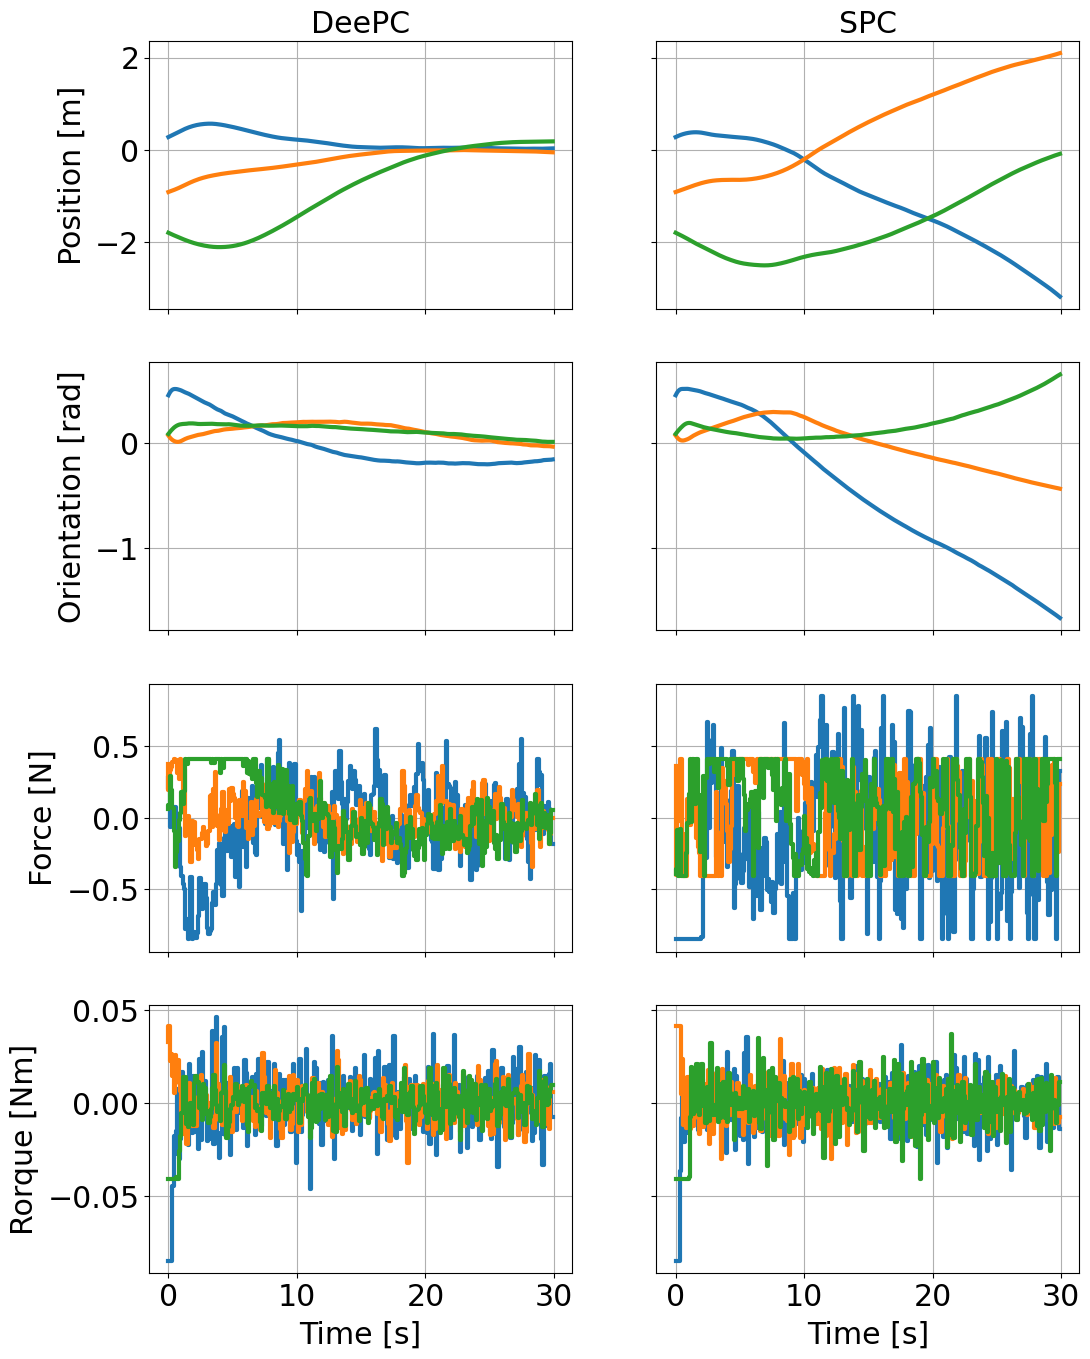

<Figure size 600x600 with 0 Axes>

In [16]:
fig, ax = plt.subplots(4,2,sharex=True, sharey='row', figsize=(12,16))

t = np.arange(300)*0.1
T_plot = 0  # Which T value to plot?
I_plot = 1  # Which Iteration to plot?

y = res_deePC[T_plot][I_plot]['y']
u = res_deePC[T_plot][I_plot]['u']
ax[0,0].plot(t,y[:,0:3])
ax[1,0].plot(t,y[:,6:9])
ax[2,0].step(t,u[:,0:3])
ax[3,0].step(t,u[:,3:6])

y = res_SPC[T_plot][I_plot]['y']
u = res_SPC[T_plot][I_plot]['u']
ax[0,1].plot(t,y[:,0:3])
ax[1,1].plot(t,y[:,6:9])
ax[2,1].step(t,u[:,0:3])
ax[3,1].step(t,u[:,3:6])

ax[0,0].set_ylabel('Position [m]')
ax[1,0].set_ylabel('Orientation [rad]')
ax[2,0].set_ylabel('Force [N]')
ax[3,0].set_ylabel('Rorque [Nm]')
ax[3,0].set_xlabel('Time [s]')
ax[3,1].set_xlabel('Time [s]')
ax[0,0].set_title('DeePC')
ax[0,1].set_title('SPC')

fig = plt.figure(figsize=(6,6))


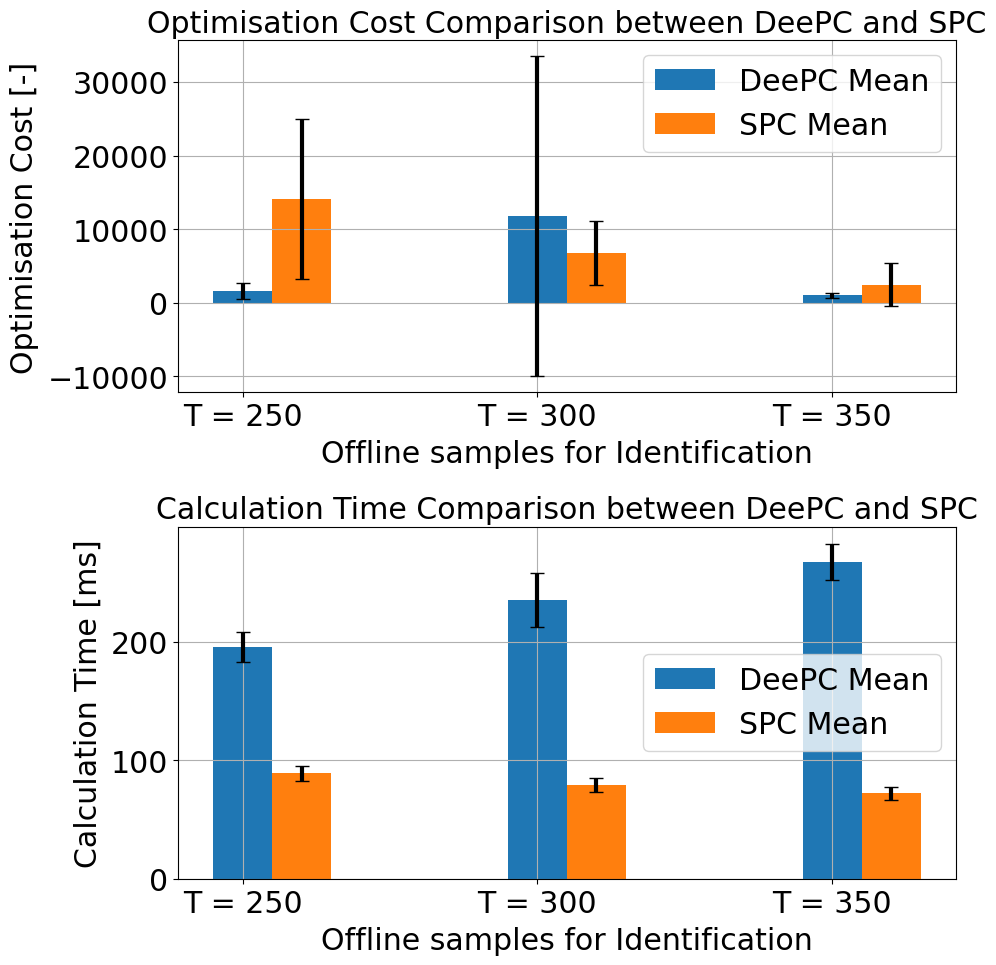

In [17]:
# Data
approaches = ['DeePC', 'SPC']
metrics = ['cost', 't_calc']
metric_labels = ['Optimisation Cost', 'Calculation Time']
metric_units = ['[-]', '[ms]']

# Create subplots for 'Optimisation Cost' and 'Calculation Time'
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, ax in enumerate(axes):
    metric = metrics[i]
    metric_label = metric_labels[i]
    metric_unit = metric_units[i]

    # Plot data for DeePC and SPC
    for approach in approaches:
        mean_values = result_summary_deePC[f'mean_{metric}'] if approach == 'DeePC' else result_summary_SPC[f'mean_{metric}']
        std_values = result_summary_deePC[f'std_{metric}'] if approach == 'DeePC' else result_summary_SPC[f'std_{metric}']
        x = np.arange(len(mean_values))
        ax.bar(x + 0.2 * approaches.index(approach), mean_values, width=0.2, label=f'{approach} Mean', yerr=std_values, capsize=5)

    # Customize each subplot
    ax.set_xlabel('Offline samples for Identification')
    ax.set_ylabel(metric_label + ' ' + metric_unit)
    ax.set_title(f'{metric_label} Comparison between DeePC and SPC')
    ax.set_xticks(x)
    ax.set_xticklabels([f'T = {t}' for t in T_arr])
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

We see that the problem is the oscillatory behavior around the origin, which is present in both methods but more pronounced with DeePC.

## Further DeePC investigation
Effect of $\lambda_g$ for $T=150$.

In [18]:
lam_g_arr = [0.01, 0.1, 1, 10]
T = 200

In [19]:
%%capture
res_deePC_T150 = []
for lam_g in lam_g_arr:
        
    # Repeat experiment 10 times.
    res = []
    for i in range(N_exp):
        np.random.seed(12)
        sys.reset(x0=np.zeros((12,1)))
        # Excitement
        n_exc = 20
        u0 = np.zeros((6,1))
        for k in range(n_exc):
            u0 = random_u(u0, u_max=u_max)
            sys.makeNonlinearStep(u0)
        
        for p in range(i):
            # Restore randomness.
            np.random.randn()

        U_L, Y_L = get_data_matrices(T, sig_w)

        S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx, ubx = setup_DeePC(U_L,Y_L,T)
        
        opt_p_num_dpc['lam_g'] = lam_g

        cost = []
        t_calc = []
        for k in range(N_sim):

            y_Tini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
            u_Tini = sys.u[-T_ini:,:]

            opt_p_num_dpc['y_Tini'] = vertsplit(y_Tini)
            opt_p_num_dpc['u_Tini'] = vertsplit(u_Tini)

            tic = time.time()
            r = S_dpc(p=opt_p_num_dpc, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
            toc = time.time()

            opt_x_num_dpc.master = r['x']    
        
            u0 = opt_x_num_dpc['u_N',0].full().reshape(-1,1)
            y0 = sys.makeNonlinearStep(u0)

            cost.append(.1*u0.T@u0+y0.T@y0)
            t_calc.append(toc-tic)


        res.append({'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost': np.concatenate(cost),'t_calc': np.array(t_calc)})
        
    res_deePC_T150.append(res)

In [20]:
result_summary_deePC_T150= {'mean_cost':[],'std_cost':[], 'mean_t_calc':[], 'std_t_calc':[]}

for res_i in res_deePC_T150:
    cost = [np.sum(res_ik['cost']) for res_ik in res_i]
    t_calc = [np.mean(res_ik['t_calc']) for res_ik in res_i]
    result_summary_deePC_T150['mean_cost'].append(np.round(np.mean(cost),3))
    result_summary_deePC_T150['std_cost'].append(np.round(np.std(cost),3))
    result_summary_deePC_T150['mean_t_calc'].append(np.round(np.mean(t_calc)*1e3,3))
    result_summary_deePC_T150['std_t_calc'].append(np.round(np.std(t_calc)*1e3,3))
    
result_summary_deePC_T150

{'mean_cost': [25969.456, 13525.107, 155.548, 31.67],
 'std_cost': [13357.365, 16062.585, 242.71, 26.187],
 'mean_t_calc': [163.655, 156.127, 132.943, 105.945],
 'std_t_calc': [7.28, 8.55, 7.872, 1.539]}